In [1]:
import numpy as np
import pandas as pd

# ML libs
import tensorflow as tf
from tensorflow import keras
import sklearn
import xgboost
import scikeras

# optimization
import keras_adabound

# Hypertuning libs
import keras_tuner
import skopt
import hyperopt

# Misc
import scipy
import matplotlib.pyplot as plt

In [2]:
cifar10 = keras.datasets.cifar10.load_data()

In [3]:
from sklearn.model_selection import train_test_split

(X_, y_), (X_test, y_test) = cifar10

dev_ratio = (len(y_test)/ len(y_))
(X_train, X_dev, y_train, y_dev) = train_test_split(X_, y_, test_size=dev_ratio)

labels = [
    "airplane",   # 0
    "automobile", # 1
    "bird",       # 2
    "cat",        # 3
    "deer",       # 4
    "dog",        # 5
    "frog",       # 6
    "horse",      # 7
    "ship",       # 8
    "truck"       # 9
]

In [4]:
X_train.shape

(40000, 32, 32, 3)

In [5]:
X_dev.shape

(10000, 32, 32, 3)

In [6]:
y_train.shape

(40000, 1)

In [7]:
def show(X, colormap="binary", axis="off"):
    plt.imshow(X, cmap=colormap)
    plt.axis(axis)
    
    plt.show()

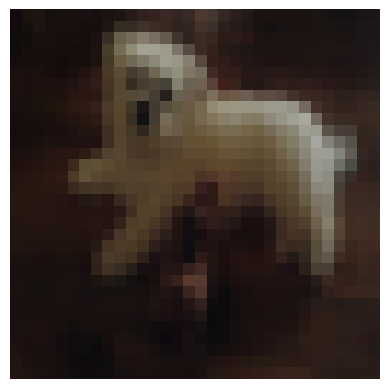

In [8]:
show(X_train[0])

In [9]:
y_train[0]

array([5], dtype=uint8)

In [10]:
x_in_shape = (32, 32, 3)
classes = len(labels)

In [60]:
import copy

from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

from sklearn.base import BaseEstimator, TransformerMixin

class Flattener(BaseEstimator, TransformerMixin):
    def __init__(self):
        print("Hi. I'm a flattener. I flatten things.")
    
    def fit(self, X, y=None):
        print("this is the part where I do something with the training set (unless the dude who uses me is dumb)")
        return self
    
    def transform(self, X, y=None):
        X_ = X.copy() # avoid changes to original dataset
        X_ = X_.ravel().reshape(-1, 1)
        print(X_.shape)
        return X_ # It's flattening time!

def tree_model(n_estimators=128):
    model = OneVsRestClassifier(XGBClassifier(n_estimators=n_estimators))
    mlb = MultiLabelBinarizer()
    
    y_tr = mlb.fit_transform(copy.deepcopy(y_train))
    
    pipe = Pipeline([
        ("preprocessor", Flattener()),
        ("model", model)
    ])
    
    pipe.fit(X_train, y_tr)
    
    score = roc_auc_score(y_dev, model.predict_proba(X_train))
    
    return model, score

In [11]:
def plotHistory(hist):
    pd.DataFrame(hist.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1) # vertical range: [0, 1]
    plt.show()

Epoch 1/5
1250/1250 [==============================] - 11s 7ms/step - loss: 2.0703 - sparse_categorical_accuracy: 0.2469 - val_loss: 1.9324 - val_sparse_categorical_accuracy: 0.2832
Epoch 2/5
1250/1250 [==============================] - 7s 6ms/step - loss: 1.8824 - sparse_categorical_accuracy: 0.3183 - val_loss: 1.7976 - val_sparse_categorical_accuracy: 0.3608
Epoch 3/5
1250/1250 [==============================] - 7s 6ms/step - loss: 1.8050 - sparse_categorical_accuracy: 0.3506 - val_loss: 1.8295 - val_sparse_categorical_accuracy: 0.3399
Epoch 4/5
1250/1250 [==============================] - 8s 6ms/step - loss: 1.7640 - sparse_categorical_accuracy: 0.3694 - val_loss: 1.7698 - val_sparse_categorical_accuracy: 0.3717
Epoch 5/5
1250/1250 [==============================] - 7s 6ms/step - loss: 1.7358 - sparse_categorical_accuracy: 0.3803 - val_loss: 1.7147 - val_sparse_categorical_accuracy: 0.3952


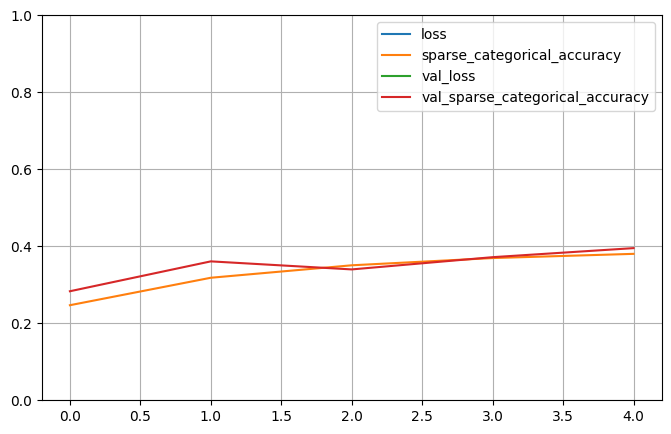

In [12]:
from keras.layers import Input, Dense, Flatten, Activation, BatchNormalization, AlphaDropout
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Nadam
from keras.metrics import SparseCategoricalAccuracy
from keras.callbacks import EarlyStopping

class MCFriendly_Dropout(AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

# stupid model: 20 hidden layers, 100 neurons each, He initialization, ELU activation
def stupid_model(optimizer=Nadam(learning_rate=0.001), batch_size=None, epochs=1, callbacks=None):
    input_ = Input(shape=x_in_shape)
    flat = Flatten()(input_)
    standardize = BatchNormalization()(flat)
    
    prev_layer = standardize
    for i in range(20):
        hidden_layer = Dense(100, kernel_initializer="lecun_normal")(prev_layer)
        act = Activation("selu")(hidden_layer)
        prev_layer = MCFriendly_Dropout(rate=0.025)(act)
    
    output_ = Dense(units=classes)(prev_layer)
    
    stupid_model = keras.Model(inputs=input_, outputs=output_)
    stupid_model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer=optimizer, 
                         metrics=[SparseCategoricalAccuracy()])
    
    history = stupid_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                               validation_data=(X_dev, y_dev), callbacks=callbacks)
    
    return (stupid_model, history)

(stupid_model, history) = stupid_model(
    optimizer=Nadam(learning_rate=0.001),
    #batch_size=5000,
    epochs=5,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
)

plotHistory(history)

In [13]:
from keras.metrics import sparse_categorical_crossentropy, sparse_categorical_accuracy

def onehot(arr, num_classes):
    def encode(c):
        ret = [0] * num_classes
        ret[c] = 1
        return ret
    
    arr_onehot = np.array([encode(c) for c in arr.ravel()])
    return arr_onehot #np.asarray(arr_onehot).astype(np.float32)

# MONTE CARLO DROPOUT

stupid_sample_size = 11
stupid_axis = 1 # shouldn't join rows; join by columns because y is a column vector

y_probas_stupid = np.stack([stupid_model.predict(
    X_dev#,
    #training=True  
) for sample in range(stupid_sample_size)], axis=stupid_axis) # training=True only needed if MCFriendly_Dropout layers not used

y_proba_stupid = y_probas_stupid.mean(axis=stupid_axis)

y_dev_onehot = onehot(y_dev, classes)

print(y_probas_stupid.shape)
print(y_proba_stupid.shape)
print(y_dev.shape)
print(y_dev_onehot.shape)

y_proba_stupid_decision = np.argmax(y_proba_stupid, axis=stupid_axis)

print(f"monte carlo dev loss of stupid_model: {sparse_categorical_crossentropy(y_dev, y_proba_stupid, from_logits=True)}")
print(f"monte carlo dev accuracy of stupid_model: {sparse_categorical_accuracy(y_dev, y_proba_stupid)}")

313/313 [==============================] - 1s 3ms/step
(10000, 11, 10)
(10000, 10)
(10000, 1)
(10000, 10)
monte carlo dev loss of stupid_model: [2.1400309  0.10602961 4.5010805  ... 2.0547743  2.405552   0.2737107 ]
monte carlo dev accuracy of stupid_model: [0. 1. 0. ... 0. 0. 1.]


In [14]:
print(f"monte carlo dev loss of stupid_model: {sparse_categorical_crossentropy(y_dev, y_proba_stupid, from_logits=True)}")
print(f"monte carlo dev accuracy of stupid_model: {sparse_categorical_accuracy(y_dev, y_proba_stupid)}")

monte carlo dev loss of stupid_model: [2.1400309  0.10602961 4.5010805  ... 2.0547743  2.405552   0.2737107 ]
monte carlo dev accuracy of stupid_model: [0. 1. 0. ... 0. 0. 1.]


In [16]:
from keras.layers import Conv2D, MaxPooling2D, PReLU, ReLU
from learning_rate_schedulers import OneCycleScheduler
import math

def awesome_model():
    a0 = Input(shape=(32, 32, 3))
    _a0_ = BatchNormalization()(a0)
    
    z1 = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding="same", kernel_initializer="glorot_uniform")(_a0_)
    _z1_ = BatchNormalization()(z1)
    a1 = Activation("elu")(_z1_)
    pool1 = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same")(a1)
    
    z2 = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding="same", kernel_initializer="glorot_uniform")(pool1)
    a2 = PReLU()(z2)
    pool2 = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same")(a2)
    
    z3 = Conv2D(64, kernel_size=(5, 5), strides=(1, 1), padding="valid", kernel_initializer="glorot_uniform")(pool2)
    _z3_ = BatchNormalization()(z3)
    a3 = ReLU()(_z3_)
    pool3 = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="valid")(a3)
    
    flat = Flatten()(pool3)
    
    # FCs
    fc_a4 = Dense(64, activation="relu")(flat)
    fc_aL = Dense(10)(fc_a4)
    
    model = keras.Model(inputs=a0, outputs=fc_aL)
    model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer=keras.optimizers.Nadam(learning_rate=0.01), metrics=[SparseCategoricalAccuracy()])
    
    return model

awesome_model = awesome_model()

n_epochs = 10
minibatch_size = 512

m_train = len(X_train)
n_iter = math.ceil(m_train / minibatch_size) * n_epochs

awesome_history = awesome_model.fit(X_train, y_train,
                                    batch_size=minibatch_size, 
                                    epochs=n_epochs,
                                    validation_data=(X_dev, y_dev),
                                    callbacks=[EarlyStopping(patience=5, restore_best_weights=True),
                                               OneCycleScheduler(iterations=n_iter, max_rate=0.07)])

plotHistory(awesome_history)

Epoch 1/10
79/79 [==============================] - 181s 2s/step - loss: 9.5236 - sparse_categorical_accuracy: 0.1087 - val_loss: 2.3037 - val_sparse_categorical_accuracy: 0.0926
Epoch 2/10
79/79 [==============================] - 178s 2s/step - loss: 2.3029 - sparse_categorical_accuracy: 0.1002 - val_loss: 2.3036 - val_sparse_categorical_accuracy: 0.0926
Epoch 3/10
79/79 [==============================] - 173s 2s/step - loss: 2.3032 - sparse_categorical_accuracy: 0.0975 - val_loss: 2.3035 - val_sparse_categorical_accuracy: 0.1004
Epoch 4/10
79/79 [==============================] - 173s 2s/step - loss: 2.3032 - sparse_categorical_accuracy: 0.0996 - val_loss: 2.3033 - val_sparse_categorical_accuracy: 0.1053
Epoch 5/10
79/79 [==============================] - 167s 2s/step - loss: 2.3036 - sparse_categorical_accuracy: 0.0967 - val_loss: 2.3052 - val_sparse_categorical_accuracy: 0.0926
Epoch 6/10
64/79 [=======================>......] - ETA: 29s - loss: 2.3035 - sparse_categorical_accuracy

KeyboardInterrupt: 

In [18]:
print(sklearn.__version__)

1.1.2


In [19]:
import sys

sys.version

'3.10.8 (tags/v3.10.8:aaaf517, Oct 11 2022, 16:50:30) [MSC v.1933 64 bit (AMD64)]'